# PREAMBLE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Taxi Project/DT_Analysis/KD Model Numerics')

In [ ]:
from numpy import *
from scipy import *
from pandas import *
from seaborn import *
import scipy as sc
import numpy as np
import pandas as pd
import seaborn as sns

import decimal,time

from scipy.special import *
from scipy import optimize

from scipy.optimize import fsolve, differential_evolution, NonlinearConstraint, Bounds

from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
# Lambda,Nu,Tau=params
# J,M,Alpha=params_adj
params=((23593/60/80**2),(10/7.5),0.0625)

In [ ]:
(23593/60/80**2)/(10/7.5)

0.046080078125

In [ ]:
QUANTILE=0.95
alpha_g=0.12
UBERS=np.arange(6000,15000,100)
TAXIS=np.arange(3000,7000,100)

# Monopoly

* $\nu=$ speed of traffic (=1)
* $\lambda=$ arrival rate of passengers at a corner (=23593/60/80**2)
* $1/\tau=$ average number of blocks driven with passenger (=1/12)

In [ ]:
def ED_taxi(Alpha,*params):

  Lambda,Nu,Tau,J,N=params

  Lambda_a=Lambda*Alpha
  ES=(J/(Nu*N))/(1-((J*Lambda_a)/(Nu*Tau*N)))
  if (Lambda_a*ES>=0) and (Lambda_a*ES<=1):
    res=dict();
    res['fleet size']=N
    res['wait']=ES/(1-Lambda_a*ES)
    res['util']=(Lambda_a*ES)/((Lambda_a * ES) + Tau)
    res['alpha_t']=Alpha
    # res['metric']=(Tau*Nu)/2
  else:
    res=dict();
    res['fleet size']=N
    res['wait']=25
    res['util']=1
    res['alpha_t']=Alpha
    # res['metric']=np.NaN
  return res


def ED_Uber(Alpha,*params):

  Lambda,Nu,Tau,J,M=params
  Lambda_a = Lambda*Alpha
  Rho_u = (Lambda_a*J)/(M*Tau*Nu)
  if (J/(M*(1-Rho_u)))>0:
    D_u = (2/(3*Nu))*math.sqrt(J/(M*(1-Rho_u)))
    res=dict();
    res['fleet size'] = M
    res['wait'] = D_u
    res['util'] = Rho_u
    res['alpha_u']=Alpha
    # res['util2'] = 1/(M*Tau*Nu/(Lambda_a*J) + D_u*Tau*Nu)
    # res['metric']=(Tau*Nu)/2
  else:
    # D_u = (2/(3*Nu))*math.sqrt(J/(M*(1-0.999)))
    res=dict();
    res['fleet size'] = M
    res['wait'] = 25 #D_u
    res['util'] = 1
    res['util2'] = 1
    res['metric']=np.NaN
    res['alpha_u']=Alpha
  return res

In [ ]:
W_t=ED_taxi(0.99,*params+(80**2,6785))['wait']
W_t

2.635013385387657

In [ ]:
df_uber=pd.DataFrame({'N': TAXIS, "T": 'float', "U_u": 'float'})

for x in range(df_uber.shape[0]):
  df_uber.at[x,'U_u']=ED_Uber(0.99,*params+(80**2,df_uber['N'][x]))['util']
  df_uber.at[x,'T']=ED_Uber(0.99,*params+(80**2,df_uber['N'][x]))['wait']

print('Possible Reduction in Fleet Size')
min(df_uber[df_uber['T']<W_t]['N']),min(df_uber[df_uber['T']<W_t]['N'])/6875

Possible Reduction in Fleet Size


(5000, 0.7272727272727273)

# Competititon

In [ ]:
def comp_base(i,*params_comp):
  J,N,M=params_comp

  # i=taxi market share

  ED_taxi_ex=ED_taxi(i,*params+(J**2,N))['wait']
  ED_UBER_ex=ED_Uber(1-i,*params+(J**2,M))['wait']
  return float(ED_taxi_ex-ED_UBER_ex)**2


def comp_UU(i,*params_comp):
  J,N,M=params_comp

  # i[0]=market share
  # i[1]=number of Ubers

  ED_taxi_ex=ED_Uber(i,*params+(J**2,N))['wait']
  ED_UBER_ex=ED_Uber(1-i,*params+(J**2,M))['wait']
  return float(ED_taxi_ex-ED_UBER_ex)**2

### Conditions in Proposition 2

If $3J/8 < N^2$ and $\bar{\rho} > \frac{\alpha^{SQ}\lambda J}{\tau \nu N}$ then ...

Lambda,Nu,Tau=params

J,M,Alpha=params_adj

params=((23593/60/80**2),(10/7.5),0.0625)

In [ ]:
(0.95*(23593/60/80**2)*80)/(0.0625*(10/7.5)*6785),(0.05*(23593/60/80**2)*80)/(0.0625*(10/7.5)*6785)

(0.008258419307295504, 0.000434653647752395)

In [ ]:
df_base=pd.DataFrame(columns=["N", "M", "T", "U_u", "alpha_u", "Fleet"])

i=6785
for j in UBERS:
  result=ED_Uber(1-differential_evolution(comp_base, bounds=[(alpha_g,0.999)], args=(80,i,j)).x[0],*params+(80**2,j))
  df_base=df_base.append({'N' : i, 'M' : j, 'T' : result['wait'],  "U_u" : result['util'], "alpha_u" : result['alpha_u'], "Fleet": i+j}, ignore_index = True)
df_base

,N,M,T,U_u,alpha_u,Fleet
0,6785.0,6000.0,0.838178,0.620426,0.788912,12785.0
1,6785.0,6100.0,0.829853,0.619120,0.800371,12885.0
2,6785.0,6200.0,0.821728,0.617816,0.811779,12985.0
3,6785.0,6300.0,0.813796,0.616515,0.823135,13085.0
4,6785.0,6400.0,0.806050,0.615217,0.834440,13185.0
...,...,...,...,...,...,...
85,6785.0,14500.0,0.393224,0.286370,0.880000,21285.0
86,6785.0,14600.0,0.391337,0.284409,0.880000,21385.0
87,6785.0,14700.0,0.389478,0.282474,0.880000,21485.0
88,6785.0,14800.0,0.387644,0.280565,0.880000,21585.0


In [ ]:
df_u=pd.DataFrame(columns=["N", "M", "T", "U_u", "alpha_u", "Fleet"])
for i in TAXIS:
  for j in UBERS:
    result=ED_Uber(1-differential_evolution(comp_UU, bounds=[(0.04,0.95)], args=(80,i,j)).x[0],*params+(80**2,j))
    df_u=df_u.append({'N' : i, 'M' : j, 'T' : result['wait'],  "U_u" : result['util'], "alpha_u" : result['alpha_u'], "Fleet": i+j}, ignore_index = True)
df_u

,N,M,T,U_u,alpha_u,Fleet
0,3000.0,6000.0,0.864534,0.643217,0.817891,9000.0
1,3000.0,6100.0,0.854611,0.640869,0.828487,9100.0
2,3000.0,6200.0,0.845022,0.638597,0.839084,9200.0
3,3000.0,6300.0,0.835749,0.636397,0.849680,9300.0
4,3000.0,6400.0,0.826775,0.634266,0.860276,9400.0
...,...,...,...,...,...,...
3595,6900.0,14500.0,0.400598,0.312404,0.960000,21400.0
3596,6900.0,14600.0,0.398604,0.310264,0.960000,21500.0
3597,6900.0,14700.0,0.396640,0.308153,0.960000,21600.0
3598,6900.0,14800.0,0.394704,0.306071,0.960000,21700.0


In [ ]:
df_best=pd.DataFrame(columns=["N", "M", "T", "U_u", "alpha_u", "Fleet"])
df_app_comp=pd.DataFrame(columns=["N", "M", "T", "U_u", "alpha_u", "Fleet"])

for j in range(df_base.shape[0]):
  for i in TAXIS:
    df_best=df_best.append(df_u[(df_u["N"]==i)&(np.abs(df_u['U_u']-df_base['U_u'][j])<0.01)&(df_base['T'][j]>df_u['T'])].sort_values(by=['M']).tail(1))

  df_app_comp=df_app_comp.append({"N": df_best.quantile(0.5)[0], "M": df_best.quantile(0.5)[1], "T": df_best.quantile(0.5)[2], \
          "U_u": df_best.quantile(0.5)[3], "alpha_u": df_best.quantile(0.5)[4], "Fleet": df_best.quantile(QUANTILE)[5]}, ignore_index=True)

df_app_comp.insert(6, "Fleet_base", np.array(df_base['Fleet']), True)
df_app_comp.insert(7, "Delta_u", np.array(df_base['Fleet']), True)
df_app_comp['Delta_u']=100*(1-(df_app_comp['Fleet']/df_app_comp['Fleet_base']))
df_app_comp['U_u']=100*(df_app_comp['U_u']-0.05)


df_app_comp

,N,M,T,U_u,alpha_u,Fleet,Fleet_base,Delta_u
0,3150.0,7050.0,0.764445,56.126239,0.913258,10400.0,12785.0,18.654673
1,3200.0,6900.0,0.771130,56.082813,0.892065,10460.0,12885.0,18.820334
2,3200.0,6950.0,0.767596,55.996341,0.897364,10500.0,12985.0,19.137466
3,3200.0,7050.0,0.760625,55.962410,0.907960,10500.0,13085.0,19.755445
4,3200.0,7150.0,0.753841,55.936486,0.918556,10500.0,13185.0,20.364050
...,...,...,...,...,...,...,...,...
85,4600.0,12500.0,0.448050,31.238848,0.960000,20900.0,21285.0,1.808786
86,4600.0,12500.0,0.448050,31.238848,0.960000,20900.0,21385.0,2.267945
87,4600.0,12500.0,0.448050,31.238848,0.960000,20900.0,21485.0,2.722830
88,4600.0,12500.0,0.448050,31.238848,0.960000,20900.0,21585.0,3.173500


# Graphix

In [ ]:
#df_app_comp=df_app_comp.set_index('U_u')

In [ ]:
#import matplotlib.pyplot as plt
#import seaborn as sns

#sns.set(rc={'figure.figsize':(6, 4)})
#g=df_app_comp.loc[:,['Fleet','Fleet_base']].plot(linewidth=4);
#g.set_ylabel('Total Vehicles on the Road (%)',fontsize = 14)
## g.set_xlabel(r'$\bar{\rho}$ (%)',fontsize = 14)
#g.set_xlabel('Uber Driver Utilization (%)',fontsize = 14)
#plt.legend(loc='lower left', labels=['E-hail Fleet Size','Status Quo Fleet Size'],fontsize = 12)
## plt.legend(loc='upper left', labels=[r'$\Delta_r$ (%)', r'$\Delta_a$ (%)'])
#plt.savefig('Nature_Reduction.png',bbox_inches='tight', pad_inches=.1)

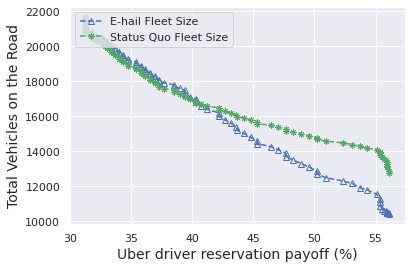

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

sns.set(rc={'figure.figsize':(6, 4)})
 
fig=plt.figure()
ax=fig.add_subplot(111)
 
ax.plot(np.array(df_app_comp['U_u']),np.array(df_app_comp['Fleet']),c='b',marker="^",ls='--', label='E-hail Fleet Size',fillstyle='none')
ax.plot(np.array(df_app_comp['U_u']),np.array(df_app_comp['Fleet_base']),c='g',marker=(8,2,0),ls='--',label='Status Quo Fleet Size')
plt.legend(loc=2)
ax.set_ylabel('Total Vehicles on the Road',fontsize = 14)
ax.set_xlabel('Uber driver reservation payoff (%)',fontsize = 14)
plt.savefig('Nature_Reduction.png',bbox_inches='tight', pad_inches=.1)
plt.show()

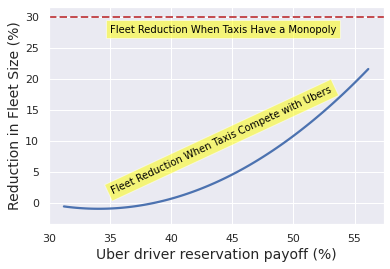

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

sns.set(rc={'figure.figsize':(6, 4)})

p=sns.regplot(x="U_u", y="Delta_u", data=df_app_comp, marker=" ", ci=None, order=2)
p.set_xlabel("X-Axis", fontsize = 14)
p.set_ylabel("Y-Axis", fontsize = 14)

p.axhline(30,linewidth=2, color='r',ls="--")

plt.text(x=35, y=27.5, s="Fleet Reduction When Taxis Have a Monopoly", fontdict=dict(color='black',size=10), bbox=dict(facecolor='yellow',alpha=0.5))
plt.text(x=35, y=1.5, rotation=25, s="Fleet Reduction When Taxis Compete with Ubers", fontdict=dict(color='black',size=10), bbox=dict(facecolor='yellow',alpha=0.5))

p.set_ylabel('Reduction in Fleet Size (%)',fontsize = 14)
p.set_xlabel('Uber driver reservation payoff (%)',fontsize = 14)
plt.savefig('Percent_Nature_Reduction.png', bbox_inches='tight', pad_inches=.1)

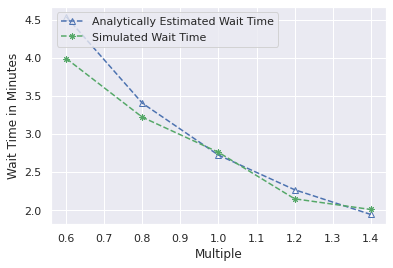

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
fig=plt.figure()
ax=fig.add_subplot(111)
 
ax.plot(np.array([0.6,0.8,1,1.2,1.4]),np.array([4.5386,3.4040,2.7232,2.2693,1.9451]),c='b',marker="^",ls='--', label='Analytically Estimated Wait Time',fillstyle='none')
ax.plot(np.array([0.6,0.8,1,1.2,1.4]),np.array([3.99,3.22,2.76,2.15,2.01]),c='g',marker=(8,2,0),ls='--',label='Simulated Wait Time')
plt.legend(loc=2)

ax.set_ylabel('Wait Time in Minutes')
ax.set_xlabel('Multiple')
plt.savefig('wait_time_comps.png',pad_inches=.1)
plt.show()